In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Define Functions

In [2]:
# Define a function to keep the first and third occurrence of each index item
def keep_first_and_third(group):
    # Keep the first and third rows of each group
    return group.iloc[[0, 2]] if len(group) >= 3 else group

In [3]:
# Define a function to assign 'Milk' and 'StM'
def assign_region(group):
    # Create a new column 'region' with default value 'StM'
    group['region'] = 'StM'
    # Set 'Milk' for the first appearance
    group.iloc[0, group.columns.get_loc('region')] = 'Milk'
    return group

In [4]:
def write_par_table(par: str,
                    reg_par: str,
                    reg_par_key: str,
                    cal_params: str,
                    lu_classes: str,
                    st_classes: str) -> pd.DataFrame:
    
    """ This function writes a table contaning all HYPE parameters based on the outputs:
    
    par: Path to the par.txt file in HYPE
    reg_par: Path to the reg_par.txt file in HYPE
    reg_par_key: Path to the key containing regionalized parameters and their regression values
    cal_params: Path to the dataframe of parameters being calibrated
    lu_classes: Path to the file containing the land use classes and what they represent
    st_classes: Path to the file containing the soil type classes and what they represent """


    # Read the file into a DataFrame, ignoring lines starting with '#'
    par = pd.read_csv(par, comment='!', delimiter='\t', header= None, index_col=0)

    # read regional parameters
    reg_par= pd.read_csv(reg_par, delim_whitespace=True, skiprows=1, header= None, index_col= 0)

    # read regional parameter regression key
    reg_par_key= pd.read_excel(reg_par_key, index_col=0)

    # read cal params
    cal_params= pd.read_csv(cal_params, delimiter='\t',header= None,index_col=0)

    # read land use classes
    lu_classes= pd.read_excel(lu_classes, sheet_name='Land Use',index_col=0)

    # read soil type classes
    st_classes= pd.read_excel(st_classes, sheet_name='Soil Type',index_col=0)
    
    # Format regionalized parameters
    
    # Apply the function to each group
    filtered_reg_par = reg_par.groupby(level=0).apply(keep_first_and_third).reset_index(level=0, drop=True)

    # Apply the function to each group
    filtered_reg_par = filtered_reg_par.groupby(0, group_keys=False).apply(assign_region)

    # Merge the DataFrames on the index
    merged_reg_par = filtered_reg_par.join(reg_par_key)

    # Multiply the values in the first column by the 'Regression' values
    merged_reg_par['Value'] = merged_reg_par[1] * merged_reg_par['Regression']

    # Drop the 'Regression' column if not needed
    merged_reg_par = merged_reg_par.drop(columns=['Regression', 1])

    # Pivot the DataFrame
    pivot_reg_par = merged_reg_par.reset_index().pivot(index= 0, columns='region', values='Value')

    # Rename index to 'Parameter'
    pivot_reg_par.index.name = 'Parameter'

    # Format parameter file
    
    # Convert index of cal_params to string
    cal_params.index = cal_params.index.astype(str)

    # Change column names in cal_params to integers
    cal_params.columns = range(cal_params.shape[1])

    # Convert index of par to string
    par.index = par.index.astype(str)

    # Convert column headers of 'par' to integers
    par.columns = par.columns.astype(int)

    # Convert index of lu_classes to int
    lu_classes.index = lu_classes.index.astype(int)

    # Convert index of st_classes to int
    st_classes.index = st_classes.index.astype(int)
    
    # Create a land use mapping dictionary
    lu_mapping = dict(zip(lu_classes.index, lu_classes.iloc[:, 0]))

    # Create a soil type mapping dictionary
    st_mapping = dict(zip(st_classes.index, st_classes.iloc[:, 0]))
    
    lu_indices = par.index.intersection(cal_params.index)
    # Filter rows where the 6th column of 'cal_params' has the value 'Land Use'
    land_use = par.loc[
        lu_indices[cal_params.loc[lu_indices].iloc[:, 6] == 'Land Use']
    ]

    # Update the DataFrame's columns using the mapping dictionary
    land_use.columns = [lu_mapping.get(col, col) for col in land_use.columns]

    # Set the name of the index
    land_use = land_use.rename_axis('Parameter')
    
    st_indices = par.index.intersection(cal_params.index)
    
    # Filter rows where the 6th column of 'cal_params' has the value 'Land Use'
    soil_type = par.loc[
        st_indices[cal_params.loc[st_indices].iloc[:, 6] == 'Soil Type']
    ]

    # Update the DataFrame's columns using the mapping dictionary
    soil_type.columns = [st_mapping.get(col, col) for col in soil_type.columns]

    # Set the name of the index
    soil_type = soil_type.rename_axis('Parameter')

    # Drop any column that contains NaN values
    soil_type = soil_type.dropna(axis=1)
    
    general_indices = par.index.intersection(cal_params.index)
    # Filter rows where the 6th column of 'cal_params' has the value 'Land Use'
    general = par.loc[
        general_indices[cal_params.loc[general_indices].iloc[:, 6] == 'General']
    ]

    # Set the name of the index
    general = general.rename_axis('Parameter')

    # Drop any column that contains NaN values
    general = general.dropna(axis=1)

    general.rename(columns={general.columns[0]: 'General'}, inplace=True)
    
    # Concatenate the DataFrames with different headers and indexes
    combined_par = pd.concat([land_use, soil_type, general, pivot_reg_par], keys=['Land Use', 'Soil Type', 'General', 'Regionalized General'])

    # Round values to 3 significant figures
    combined_par = combined_par.round(3)
    
    return combined_par

In [5]:
def filter_by_sensitivity(par: pd.DataFrame) -> pd.DataFrame:
    # List of exact keywords to filter the columns (most dominant lu/st)
    keywords = [
        '05_Milk_Temperate or sub-polar grassland', 
        '13_StM_Temperate or sub-polar needleleaf forest', 
        '03_Milk_Clay loam', 
        '13_StM_Loam',
        'Milk', # Regionalized par for Milk
        'StM' # Regionalized par for StM
    ]
    
    # Creating a boolean mask for exact column selection based on keywords
    mask = par.columns.isin(keywords)

    # Filtering the DataFrame to keep only the desired columns
    filtered_par = par.loc[:, mask]

    # Drop any row with only NaN values
    filtered_par = filtered_par.dropna(how='all')
    
    return filtered_par

In [6]:
def mean_rows(par: pd.DataFrame) -> pd.DataFrame:
    # List of exact keywords to filter the columns (most dominant lu/st)
    
    # Creating a boolean mask for each set of columns (Milk and StM)
    milk_mask = par.columns.str.contains('Milk')
    stm_mask = par.columns.str.contains('StM')
    
    # Filtering columns based on the masks and summing across each row
    milk_mean = par.loc[:, milk_mask].mean(axis=1)
    stm_mean = par.loc[:, stm_mask].mean(axis=1)
    
    # Creating a new DataFrame with the summed columns
    result_df = pd.DataFrame({'Milk_Sum': milk_mean, 'StM_Sum': stm_mean})
    
    # Drop any row where both sums are NaN (in case all values were NaN)
    result_df = result_df.dropna(how='all')
    
    return result_df

In [7]:
def find_difference(par1: pd.DataFrame, par2: pd.DataFrame)-> pd.DataFrame:
    
    # Check if both DataFrames have the same index and columns
    if par1.index.equals(par2.index) and par1.columns.equals(par2.columns):
        # Subtract par2 from par1
        result = par1 - par2
        
        return result
    
    else:
        mismatch_info = []
        if not par1.index.equals(par2.index):
            mismatch_info.append(f"Indexes do not match: par1 index = {par1.index}, par2 index = {par2.index}")
        if not par1.columns.equals(par2.columns):
            mismatch_info.append(f"Headers do not match: par1 headers = {par1.columns}, par2 headers = {par2.columns}")
            
        return "\n".join(mismatch_info)

In [8]:
def normalize_params(par_nse_filtered, cal_params_path):
    # Read calibration parameters and select the range columns (min and max)
    cal_params = pd.read_csv(cal_params_path, delimiter='\t', header=None, index_col=0)
    
    # Store the full original multi-index for later reassignment
    original_index = par_nse_filtered.index
    
    # Reset only the second level of the index for merging
    par_nse_filtered_reset = par_nse_filtered.droplevel(0)
    
    # Merge with cal_params based on the reset index
    merged_df = par_nse_filtered_reset.merge(cal_params.iloc[:, 1:3], left_index=True, right_index=True, how="left")
    
    # Normalize columns except the range columns (2 and 3)
    min_values = merged_df[2]
    max_values = merged_df[3]
    for col in merged_df.columns.difference([2, 3]):
        merged_df[col] = (merged_df[col] - min_values) / (max_values - min_values)
    
    # Drop the range columns after normalization
    merged_df = merged_df.drop(columns=[2, 3])
    
    # Reassign the full original multi-index to merged_df
    merged_df.index = original_index
    
    return merged_df

### Inputs

In [9]:
# Define paths that apply to all parameter sets
# read regional parameter regression key
reg_par_key_path= '../../geospacial/misc/reg_par_key.xlsx'

# read cal params
cal_params_path= '../../calibration/cal_param.txt'

# read land use classes
lu_classes_path= '../../geospacial/misc/lu_st_classes.xlsx'

# read soil type classes
st_classes_path= '../../geospacial/misc/lu_st_classes.xlsx'

output_fig_path= '../../model/model_versions/v_7/v7_1/hds_model/parameter_differences.png'

### Analysis

In [10]:
# Define model specific parameter paths
par_path_nse= '../../model/model_versions/v_7/v7_1/hds_model/par.txt'

# read regional parameters
reg_par_path_nse= '../../model/model_versions/v_7/v7_1/hds_model/reg_par.txt'

# generate table
par_nse= write_par_table(par_path_nse, reg_par_path_nse, reg_par_key_path, 
                         cal_params_path, lu_classes_path, st_classes_path)

C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_34092\2908722352.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  reg_par= pd.read_csv(reg_par, delim_whitespace=True, skiprows=1, header= None, index_col= 0)


In [11]:
# filter by most dominant lu and st
par_nse_filtered= filter_by_sensitivity(par_nse)

In [12]:
mean_rows= mean_rows(par_nse)

In [13]:
# find difference (par1-par2)
# difference= find_difference(par_nse_filtered, par_kge_filtered)

In [14]:
# Normalize parameter ranges
normalized_df = normalize_params(par_nse_filtered, cal_params_path)

In [15]:
# normalized_df= normalize_params(mean_rows, cal_params_path)

In [16]:
# Remove the upper level of the multi-level index
normalized_df.index = normalized_df.index.get_level_values(1)  # Keep the second level of the index

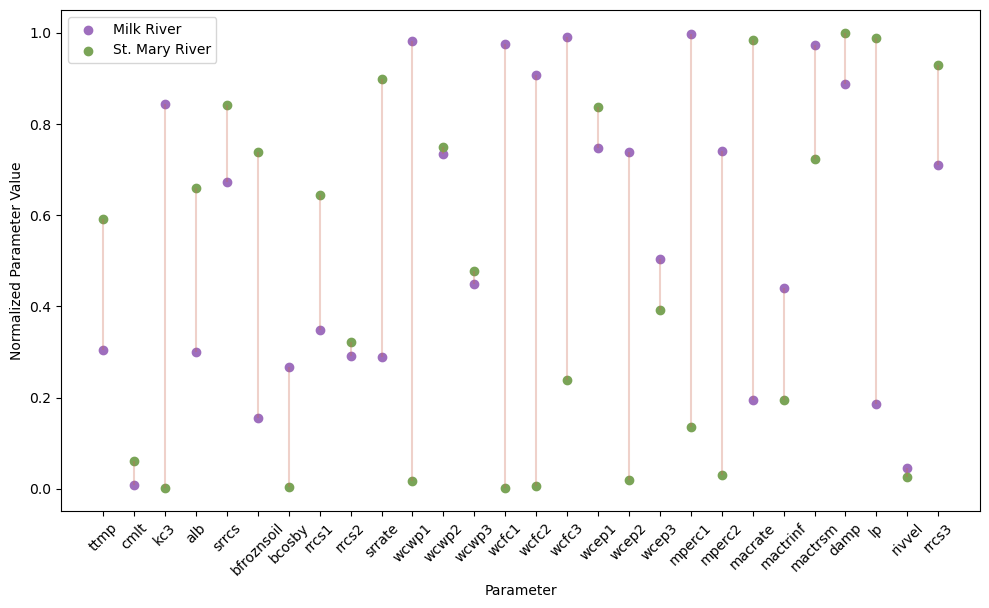

In [17]:
# Set up the plot
plt.figure(figsize=(10, 6.18))

# Store the custom labels and their corresponding colors
custom_legend_labels = {
    'Milk': 'Milk River',
    'StM': 'St. Mary River'
}
colors = {
    'Milk': "#9e6ebd",  # Color for Milk
    'StM': "#7aa457",   # Color for StM
    'Shading': "#cb6751"  # Color for Shading lines 
}

# Track whether the label has been added to the legend
added_labels = {'Milk': False, 'StM': False}

# Prepare the lists to store x and y values for shading
milk_x = []
milk_y = []
stm_x = []
stm_y = []

# Iterate through each parameter column in normalized_df to plot each value
for col in normalized_df.columns:
    # Check if the column relates to "Milk"
    if 'Milk' in col:
        # Filter out NaN values
        milk_x_col = normalized_df.index[~normalized_df[col].isna()]
        milk_y_col = normalized_df[col].dropna()

        # Store x and y values for Milk
        milk_x.extend(milk_x_col)  
        milk_y.extend(milk_y_col)  

        color = colors['Milk']
        label = custom_legend_labels['Milk']

        # Plot the non-NaN values of Milk
        if not added_labels['Milk']:  # Only add label once
            plt.scatter(milk_x_col, milk_y_col, color=color, label=label)
            added_labels['Milk'] = True
        else:
            plt.scatter(milk_x_col, milk_y_col, color=color)

    # Check if the column relates to "StM"
    elif 'StM' in col:
        # Filter out NaN values
        stm_x_col = normalized_df.index[~normalized_df[col].isna()]
        stm_y_col = normalized_df[col].dropna()

        # Store x and y values for StM
        stm_x.extend(stm_x_col)
        stm_y.extend(stm_y_col)

        color = colors['StM']
        label = custom_legend_labels['StM']

        # Plot the non-NaN values of StM
        if not added_labels['StM']:  # Only add label once
            plt.scatter(stm_x_col, stm_y_col, color=color, label=label)
            added_labels['StM'] = True
        else:
            plt.scatter(stm_x_col, stm_y_col, color=color)

# Shade the area between the two dots (Milk and StM) as vertical bars
for i in range(len(milk_x)):
    if i < len(stm_x):  # Ensure there's a corresponding StM value for each Milk
        plt.vlines(milk_x[i], stm_y[i], milk_y[i], color=colors['Shading'], alpha=0.3)  # Vertical line for shading

# Set labels for the plot
plt.xlabel('Parameter')
plt.ylabel('Normalized Parameter Value')
# plt.title('Normalized Parameter Values')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add the legend, which will only have one entry for each label
plt.legend()

# Display the plot
plt.tight_layout()
plt.savefig(output_fig_path)
plt.show()